# <font color='blue'> MSiA 422 Project 1
## Written by Parth Patel

### IMPORTS

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

## <font color='orange'> Exercise 1

In [2]:
path = 'namesbystate' # needs to be updated for anyone who uses this code
all_files = glob.glob(os.path.join(path, "*.txt"))

dframes = []
for item in all_files:
    df = pd.read_csv(item,header=None,names=['State','Gender','birth_year','first_name','name_count'])
    dframes.append(df)

combined_df = pd.concat(dframes, axis=0, ignore_index=True)

In [245]:
class BabyNames:
    '''
    FILL OUT DOCSTRING BB
    '''
    #part 2a
    def __init__(self,path):
        all_files = glob.glob(os.path.join(path, "*.txt"))
        dframes = []
        for item in all_files:
            data = pd.read_csv(item,header=None,names=['State','Gender','birth_year','first_name','name_count'])
            dframes.append(data)
        self.df = pd.concat(dframes, axis=0, ignore_index=True)
        
    #part 2b
    def Count(self,state=None,year=None):
        if ((state!=None)&(year!=None)):
            out_df = self.df[(self.df.State==state.upper())&(self.df.birth_year == year)]
        
        elif ((state==None)&(year!=None)):
            out_df = self.df[self.df.birth_year == year]
            
        elif ((state!=None)&(year==None)):
            out_df = self.df[self.df.State == state]
        
        else:
            out_df = self.df
            
        if out_df.empty:
            print("There were no results for this combination of inputs. There may have been an error with your inputs. Please provide two letter abbrev for states in form of a string and the year as a 4 digit integer. Not providing an arg for either or both is acceptable as well.")
        else:
            print('Total number of births for this combination of inputs:(state: {}, year: {}):'.format(state,year))
            return sum(out_df['name_count'])
        
    #part 2c:
    def Top10BabyNames(self,state=None,year=None):
        
        self.rank_df = pd.DataFrame()
        self.rank_df['Rank'] = list(range(1,11))
        
        if ((state!=None)&(year!=None)):
            tmp_df = self.df[(self.df.State==state.upper())&(self.df.birth_year == year)]
            tmp_df = tmp_df.groupby(['Gender','first_name']).agg({'name_count':'sum'}).reset_index()
            self.rank_df['Male'] = tmp_df[tmp_df['Gender']=='M'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
            self.rank_df['Female'] = tmp_df[tmp_df['Gender']=='F'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
        
        
        elif ((state==None)&(year!=None)):
            tmp_df = self.df[self.df.birth_year == year]
            tmp_df = tmp_df.groupby(['Gender','first_name']).agg({'name_count':'sum'}).reset_index()
            self.rank_df['Male'] = tmp_df[tmp_df['Gender']=='M'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
            self.rank_df['Female'] = tmp_df[tmp_df['Gender']=='F'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
        else:
            tmp_df = self.df
            tmp_df = tmp_df.groupby(['first_name','Gender']).sum().reset_index()
            self.rank_df['Male'] = tmp_df[tmp_df['Gender']=='M'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
            self.rank_df['Female'] = tmp_df[tmp_df['Gender']=='F'].sort_values(by='name_count',ascending=False).reset_index()[:10]['first_name']
        
        if self.rank_df.empty:
            print("There were no results for this combination of inputs (state: {}, year: {}). There may have been an error with your inputs. Please provide two letter abbrev for states in form of a string and the year as a 4 digit integer. Not providing an arg for either or both is acceptable as well.".format(state,year))
        else:
            print('Top 10 male & female names for this combination of inputs (state: {}, year: {}):'.format(state,year))
            return self.rank_df
        
    #part 2d:
    def ChangeOfPopularity(self,fromYear, toYear, top):
        fromYr_df = self.df[self.df.birth_year == fromYear].groupby(['first_name']).agg({'name_count':'sum'})
        toYr_df = self.df[self.df.birth_year == toYear].groupby(['first_name']).agg({'name_count':'sum'})
        self.popularity_df = pd.merge(fromYr_df,toYr_df,how='outer',on='first_name').fillna(0)
        self.popularity_df['pop_change'] = self.popularity_df['name_count_y']- self.popularity_df['name_count_x']
        self.popularity_df['pop_change'] = self.popularity_df['pop_change'].astype(int)
        self.popularity_df.sort_values(by='pop_change',ascending=False,inplace=True)
        self.popularity_df.reset_index(inplace=True)
        self.pop_inc = self.popularity_df[:top][['first_name','pop_change']]
        self.pop_dec = self.popularity_df[-top:][['first_name','pop_change']].sort_values(by='pop_change')
        self.pop_same = self.popularity_df[self.popularity_df['pop_change']==0]['first_name']
        
        return print("Names that increased in popularity:\n", self.pop_inc,"\n Names that decreased in popularity:\n",
                     self.pop_dec,"\n Names that remained constant in popularity:\n",self.pop_same)
        
        
    #part 2e:
    def Top5NamesPerYear(self,year,sex):            
        tmp_df = self.df[(self.df.birth_year == year)&(self.df.Gender == sex)]
        tmp_df = tmp_df.sort_values(by='name_count',ascending = False)
        tmp_df_grpd = tmp_df.groupby('State').head(5)
        tmp_df_grpd.sort_values(by=['State','name_count'],ascending=[True,False])
        tmp_df_grpd['rank'] = tmp_df_grpd.groupby("State")["name_count"].rank("first", ascending=False)
        df_tmp_final = tmp_df_grpd.pivot_table(index='State',columns=['rank'],values=['name_count','first_name'],aggfunc='first')
        
        self.top5df = pd.DataFrame(index=df_tmp_final.index)
        for i in list(range(1,6)):
            self.top5df['Rank {}'.format(i)] = df_tmp_final['first_name'][i]
            self.top5df['Num for Rank {}'.format(i)] = df_tmp_final['name_count'][i]
        
        return self.top5df
    
    #part 2f:
    def NamePopularityPlot(self,name, yearRange,state,sex):
        
        if state != None:
            tmp_df = self.df[(self.df['first_name'] == name)&(self.df['birth_year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['State'] == state)&(self.df['Gender']==sex)]
            tmp_df_full = self.df[(self.df['birth_year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['State'] == state)&(self.df['Gender']==sex)]
            tmp_df_full.rename(columns={"name_count":"total_count"},inplace=True)
            tmp_df_full_grpd = tmp_df_full.groupby('birth_year').agg({'total_count':'sum'}).reset_index()
        else:
            tmp_df = self.df[(self.df['first_name'] == name)&(self.df['birth_year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['Gender']==sex)]
            tmp_df = tmp_df.groupby('birth_year').agg({"birth_year":'first',"first_name":'first',"name_count":"sum"}).reset_index(drop=True)
            tmp_df_full = self.df[(self.df['birth_year'].isin(list(range(yearRange[0],yearRange[1]))))&(self.df['Gender']==sex)]
            tmp_df_full.rename(columns={"name_count":"total_count"},inplace=True)
            tmp_df_full_grpd = tmp_df_full.groupby('birth_year').agg({'total_count':'sum'}).reset_index()
        

        self.name_pop_df = pd.merge(tmp_df,tmp_df_full_grpd,how = 'inner',on='birth_year')
        self.name_pop_df['pop_proportion'] = 100*(self.name_pop_df.name_count/self.name_pop_df.total_count)
        
        ax=self.name_pop_df.plot('birth_year','pop_proportion',kind='scatter',figsize=(12,10))
        ax.set(xlabel = 'Year',ylabel= 'Count of Babies Named {}/Total Number of Babies Born in the Year'.format(name))
        ax.set(title = 'Name Popularity Plot')
        
        return self.name_pop_df
    
    #part 2g
    def NameFlip(self,n=10):
        tmp_df = self.df.groupby(['Gender','first_name','birth_year']).count()
        tmp_df = tmp_df.unstack(0)
        tmp_df = tmp_df.drop(columns='State')
        tmp_df_2 = tmp_df.dropna().reset_index()
        tmp_df_2.columns= tmp_df_2.columns.droplevel()
        tmp_df_2.columns = ["first_name", "birth_year","F","M"]
        tmp_df_2['gen_dom'] = tmp_df_2['F'] > tmp_df_2['M']
        tmp_df_2['gen_dom'] = ['F' if x == True else 'M' for x in tmp_df_2['gen_dom']]
        tmp_df_2['gen_dom_prev'] = tmp_df_2.groupby('first_name')['gen_dom'].shift()
        tmp_df_2['flip'] = [0 if (tmp_df_2['gen_dom'][i] == tmp_df_2['gen_dom_prev'][i]) else (0 if pd.isna(tmp_df_2['gen_dom_prev'][i]) else 1) for i in range(len(tmp_df_2))]
        self.flips_df = tmp_df_2.groupby('first_name').sum().reset_index()[['first_name','flip']]
        self.flips_df=self.flips_df[self.flips_df['first_name']!='Unknown']
        self.flips_df.sort_values(by='flip',ascending=False,inplace = True)
        self.flips_df = self.flips_df[:n]
        self.flips_df.plot(kind='bar',x='first_name',y='flip')
        return self.flips_df

In [246]:
baby = BabyNames('namesbystate')

In [247]:
baby.Count(state='NY',year=2000)

Total number of births for this combination of inputs:(state: NY, year: 2000):


214844

In [248]:
baby.Top10BabyNames(year=2000)

Top 10 male & female names for this combination of inputs (state: None, year: 2000):


,Rank,Male,Female
0,1,Jacob,Emily
1,2,Michael,Hannah
2,3,Matthew,Madison
3,4,Joshua,Ashley
4,5,Christopher,Sarah
5,6,Nicholas,Alexis
6,7,Andrew,Samantha
7,8,Joseph,Jessica
8,9,Daniel,Elizabeth
9,10,Tyler,Taylor


In [249]:
baby.ChangeOfPopularity(2015,2016,10)

Names that increased in popularity:
   first_name  pop_change
0    Adeline        1709
1  Charlotte        1690
2      Mateo        1535
3     Oliver        1376
4     Bryson        1249
5    Lincoln        1128
6      Riley        1019
7    Adaline         986
8   Benjamin         937
9     Amelia         901 
 Names that decreased in popularity:
       first_name  pop_change
11100      Logan       -1654
11099     Jayden       -1490
11098      Jacob       -1464
11097      Mason       -1383
11096     Sophia       -1290
11095      Alexa       -1276
11094      Ethan       -1263
11093      Aiden       -1247
11092  Alexander       -1143
11091    Madison       -1106 
 Names that remained constant in popularity:
 5055       Theodora
5056         Adisyn
5057        Lourdes
5058         Tirzah
5059         Jamier
5060        Lynelle
5061          Fanny
5062        Salmaan
5063        Juliano
5064            Sai
5065          Lyriq
5066         Aditya
5067          Khali
5068          Lumen
506

In [250]:
baby.Top5NamesPerYear(2015,'M')

C:\Users\pspat\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Rank 1,Num for Rank 1,Rank 2,Num for Rank 2,Rank 3,Num for Rank 3,Rank 4,Num for Rank 4,Rank 5,Num for Rank 5
State,,,,,,,,,,
AK,Liam,53,Noah,48,James,46,William,44,Oliver,41
AL,William,413,James,322,John,318,Mason,294,Elijah,279
AR,William,197,Elijah,172,Mason,171,Noah,169,James,146
AZ,Noah,445,Liam,414,Alexander,370,Michael,347,Ethan,341
CA,Noah,2767,Jacob,2556,Ethan,2477,Daniel,2472,Matthew,2437
CO,Liam,306,William,276,Jackson,271,Oliver,256,Alexander,256
CT,Noah,216,Mason,211,Alexander,188,Liam,184,Benjamin,178
DC,William,78,Henry,75,James,68,Alexander,64,Jacob,62
DE,Noah,60,Mason,60,Liam,60,Jackson,53,Michael,51


In [251]:
baby.NamePopularityPlot(name='Matthew', yearRange=(2000,2015), state='IL', sex='M')

AttributeError: 'BabyNames' object has no attribute 'NamePopularityPlot'

In [ ]:
baby.NameFlip()

## <font color='orange'> Exercise 2

In [158]:
import pymysql

In [217]:
conn = pymysql.connect(user='root', \
      password='', \
      host= '127.0.0.1', \
      port=3306, \
      db='world', \
      autocommit=True)

In [218]:
df_country = pd.read_sql_query('select * from Country', con=conn)
df_country.keys()

Index(['Code', 'Name', 'Continent', 'Region', 'SurfaceArea', 'IndepYear',
       'Population', 'LifeExpectancy', 'GNP', 'GNPOld', 'LocalName',
       'GovernmentForm', 'HeadOfState', 'Capital', 'Code2'],
      dtype='object')

### Problem 1

#### Pandas Solution

In [219]:
df_p1_pandas = df_country[df_country['Population']>50000000].sort_values(by = 'Population',ascending = False)[:10].reset_index(drop=True)
df_p1_pandas

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
2,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
4,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


#### SQL Solution

In [220]:
df_p1_sql = pd.read_sql_query('select * from country where population > 50000000 order by population DESC limit 10', con=conn)
df_p1_sql

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
2,USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
4,BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754,NG


#### compare the two

In [221]:
(df_p1_pandas == df_p1_sql).any(1)

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

### Problem 2

#### Pandas

In [222]:
df_p2_pandas = df_country.groupby('Continent').agg({'Code':'count','Population':'sum'})
df_p2_pandas = df_p2_pandas[df_p2_pandas['Population'] > 0].sort_values(by='Continent',ascending = True).reset_index().rename(columns = {'Code':'Number_Countries'})

In [223]:
df_p2_pandas

,Continent,Number_Countries,Population
0,Africa,58,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,28,30401150
5,South America,14,345780000


#### SQL

In [224]:
df_p2_sql = pd.read_sql_query('select Continent, count(*) As Number_Countries, sum(population) As Population \
from country \
where population > 0 \
group by Continent \
order by 1 ASC', con=conn)

In [225]:
df_p2_sql

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


### Problem 3

#### Pandas

In [226]:
df_city = pd.read_sql_query('select * from City', con=conn)
df_p3_pandas = df_city[['Name','Population','CountryCode']]
df_p3_pandas = df_p3_pandas.merge(df_country,left_on = 'CountryCode',right_on = 'Code',how='inner')
df_p3_pandas = df_p3_pandas[df_p3_pandas['Code']=='USA']
df_p3_pandas= df_p3_pandas[['Name_x','Population_x']]
df_p3_pandas.columns = ['City','Population']
df_p3_pandas = df_p3_pandas.sort_values(by='Population',ascending=False).reset_index(drop=True)[:10]

In [227]:
df_p3_pandas

,City,Population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


#### SQL

In [228]:
df_p3_sql = pd.read_sql_query('select city.Name As City, city.population \
                                from city \
                                inner join country ON city.CountryCode = country.code \
                                where country.code = "USA" \
                                order by city.population DESC limit 10', con = conn)


In [229]:
df_p3_sql

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


### Problem 4

#### Pandas

In [230]:
df_countrylang = pd.read_sql_query('select * from countrylanguage', con=conn)

In [231]:
df_p4_pandas = df_countrylang[df_countrylang['IsOfficial']=='T'].merge(df_country, left_on = 'CountryCode',right_on = 'Code')[['Name','Language','Percentage','Population']]

df_p4_pandas['(Percentage * population) / 100'] = (df_p4_pandas.Percentage*df_p4_pandas.Population)/100

df_p4_pandas = df_p4_pandas.sort_values(by = '(Percentage * population) / 100',ascending = False).reset_index(drop=True)[:10][['Name','Language','(Percentage * population) / 100']]

In [232]:
df_p4_pandas

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


#### SQL

In [233]:
df_p4_sql = pd.read_sql_query('select country.Name, Language, (Percentage * population) / 100 \
from countrylanguage \
inner join country on countrylanguage.CountryCode = country.code \
where IsOfficial = True \
order by 3 DESC limit 10',con=conn)

In [234]:
df_p4_sql

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044512e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


### Problem 5

#### Pandas

In [235]:
df_p5_pandas = df_countrylang.merge(df_country, left_on = 'CountryCode',right_on = 'Code',how='inner')
df_p5_pandas = df_p5_pandas[['Name','Language','Percentage','Population']]
df_p5_pandas['(Percentage * population) / 100'] = (df_p5_pandas.Percentage*df_p5_pandas.Population)/100

In [236]:
df_p5_pandas=df_p5_pandas.groupby('Language').agg({'(Percentage * population) / 100':'sum'}).sort_values(by = '(Percentage * population) / 100',ascending = False).reset_index()[:5]

In [237]:
df_p5_pandas

,Language,(Percentage * population) / 100
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


#### SQL

In [238]:
df_p5_sql = pd.read_sql_query('select Language, sum((Percentage * population) / 100) \
                                from countrylanguage \
                                inner join country ON countrylanguage.CountryCode = country.code \
                                group by Language \
                                order by 2 desc limit 5', con=conn)

In [239]:
df_p5_sql

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


## <font color='orange'> Exercise 3 Create a Story

The analysis shown below shows how US baby names trend with popular athelete names. Namely, they seem to spike at the early part of a superstar athletes career, peaking with in trend with the athlete's success.  However, if the athlete continues to dominate after their initial burst onto the scene, name trends tend to return to normal levels before the athlete became nationally famous. 

In this case of Kobe Bryant, he entered the NBA league in 1997 and you can see a significant spike in that name being used that year and it continues to rise as he began to dominate in the league betwee 2000-2003.  However there is a sharp drop off after 2003 and this might be linked to the fact that he arrersted on a sexual assault charge in mid-late 2003.

In the case of Serena Williams she entered the professional tennis scene in 1995 and you can see a significant surge in the usage of the name from that point through the year 2000. Serena was one of the most exciting players in tennis due to her being extremely young and her success/poise against the veterans in the tennis scene. However as she began to become one of the veteran's herself, while she continued to dominate, the usuage of the name began to reduce once again as the 'hype' factor was now reduced.

#### Kobe Bryant

In [252]:
baby.NamePopularityPlot(name='Kobe', yearRange=(1990,2015), state=None, sex='M')

AttributeError: 'BabyNames' object has no attribute 'NamePopularityPlot'

,birth_year,first_name,name_count,total_count,pop_proportion
0,1996,Kobe,37,1728265,0.002141
1,1997,Kobe,304,1714812,0.017728
2,1998,Kobe,1093,1733469,0.063053
3,1999,Kobe,829,1736504,0.047740
4,2000,Kobe,1418,1770226,0.080103
5,2001,Kobe,1538,1745284,0.088123
6,2002,Kobe,1383,1740416,0.079464
7,2003,Kobe,1199,1768724,0.067789
8,2004,Kobe,594,1771147,0.033538
9,2005,Kobe,411,1777966,0.023116


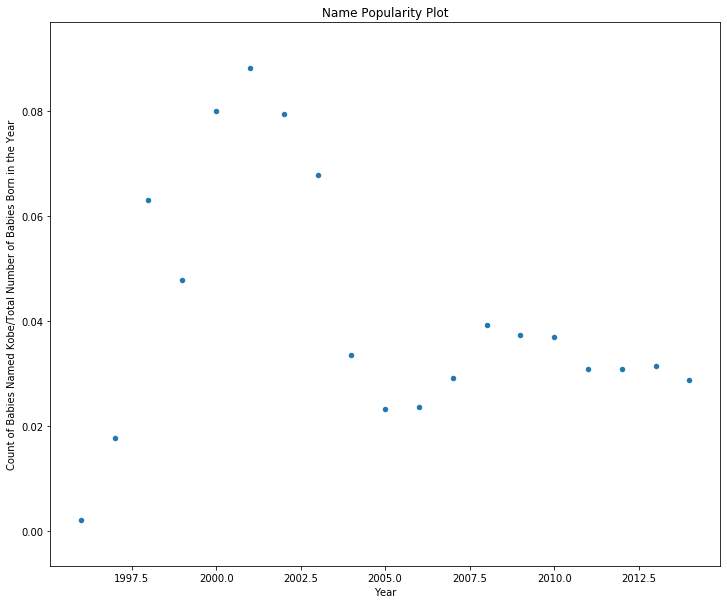

In [241]:
baby.NamePopularityPlot(name='Kobe', yearRange=(1990,2015), state=None, sex='M')

#### Serena Williams

,birth_year,first_name,name_count,total_count,pop_proportion
0,1990,Serena,409,1657466,0.024676
1,1991,Serena,453,1629956,0.027792
2,1992,Serena,437,1596161,0.027378
3,1993,Serena,490,1559039,0.031430
4,1994,Serena,567,1534655,0.036946
5,1995,Serena,796,1507124,0.052816
6,1996,Serena,889,1497302,0.059373
7,1997,Serena,1170,1479010,0.079107
8,1998,Serena,1382,1496709,0.092336
9,1999,Serena,1408,1497544,0.094021


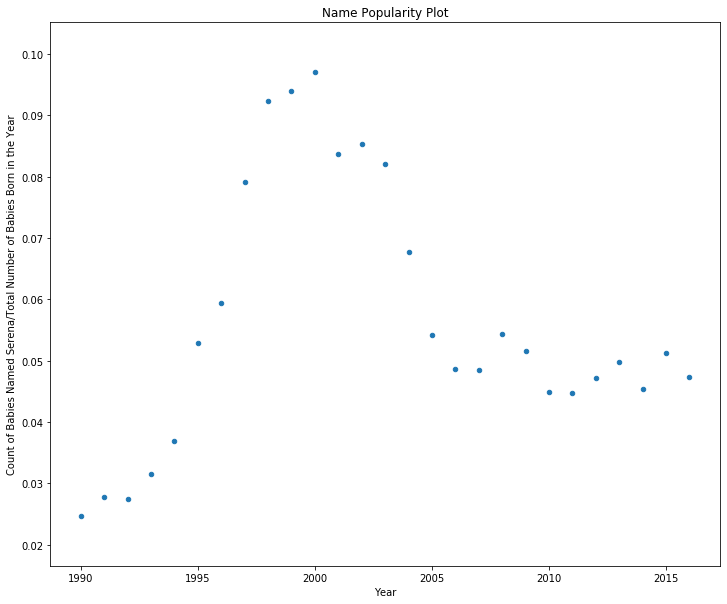

In [242]:
baby.NamePopularityPlot(name='Serena', yearRange=(1990,2017), state=None, sex='F')